[UNet with custom loss function and metrics](https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/df9eb77f0ac3b84ae125b6b177ef2e4429818d66/data.py#L49)

# libs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# metric and loss

In [2]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
def unet():
    # input shape specification
    inputs = Input(shape=(640,640,3))
    
    # conv block 1
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv1)
    
    
    # conv block 2
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2,2))(conv2)
    
    
    # conv block 3
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2,2))(conv3)
    
    
    # bottleneck
    conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(conv4)
    
    
    # upconv block 3
    up5 = concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv4),conv3],axis=3)
    conv5 = Conv2D(128, (3,3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3,3), activation='relu', padding='same')(conv5)
    
    
    # upconv block 2
    up6 = concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv5),conv2],axis=3)
    conv6 = Conv2D(64, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3,3), activation='relu', padding='same')(conv6)
    
    
    # upconv block 1
    up7 = concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv6),conv1],axis=3)
    conv7 = Conv2D(32, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3,3), activation='relu', padding='same')(conv7)
    
    
    # output block
    op = Conv2D(1,(1,1),activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[op])
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    
    
    return model

In [4]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 640, 640, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 640, 640, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 320, 320, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io


from loadData import LoadBin
from visualize.plots import Plots



ldBin_ob = LoadBin()
plt_ob = Plots()

In [6]:
apple_df = joblib.load("./picklefiles/train_dataframes/train_apple_df.53")

In [7]:
cat_id = 53

mask_path_root = "./picklefiles/1CH_train_masks/"+str(cat_id)+"/"+str(cat_id)+"."
mask_path_root

'./picklefiles/1CH_train_masks/53/53.'

In [8]:
def resize_image(a,newshape):
    return resize(a,output_shape=newshape)

In [9]:
def to_float(a):
    return np.float32(a)

(639, 640, 3)


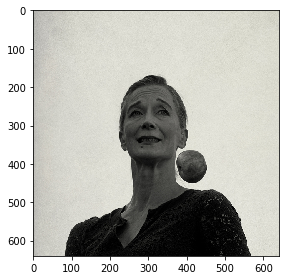

In [10]:
im = io.imread("../data/coco/train2017/000000572090.jpg")
print(im.shape)
im_resized = resize_image(im,(640,640,3))
io.imshow(im_resized)

In [12]:
img = []
mask = []
for x,i in enumerate(apple_df.values):
    
    if x == 1:
        break
        
    print(i[1])
    img_read = plt.imread(i[1])
    
    img_read = resize_image(img_read,newshape=(640,640,3))
    img_read = to_float(img_read)
    img.append(img_read)
    
    mask_path = mask_path_root+str(i[0])+".dat"
    mask_read = joblib.load(mask_path)
    
    mask_read = resize_image(mask_read,newshape=(640,640,1))
    mask_read = to_float(mask_read)
    
    mask.append(mask_read)

../data/coco/train2017/000000572090.jpg


In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1057916770294833720
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9838486993445745770
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8318760854916797608
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1160642560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5969356152661865080
physical_device_desc: "device: 0, name: GeForce 920M, pci bus id: 0000:08:00.0, compute capability: 3.5"
]


In [ ]:
with tf.device("CPU:0"):
    model.fit([img],[mask])

Train on 1 samples
